# Bootstrap Experiments

Try different ways to quantify "significance" of important features.

Contents
- Algorithms: (regularized) linear logistic regression, random forest, gradient boosted machine
- Feature Importances: coefficients, tree feature importance, permutation importance

TODO
- compare results for sample size: N=100 vs 200, 500, 1000
- plot LR coefs for effect, with importance from GBM, together in one plot
- ICE plots

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

In [2]:
%matplotlib inline

# Data

In [4]:
random_state = 99

X, y = make_classification(n_samples=100,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=random_state,
                           shuffle=False)

columns = [str(x) for x in range(X.shape[1])]

<AxesSubplot:>

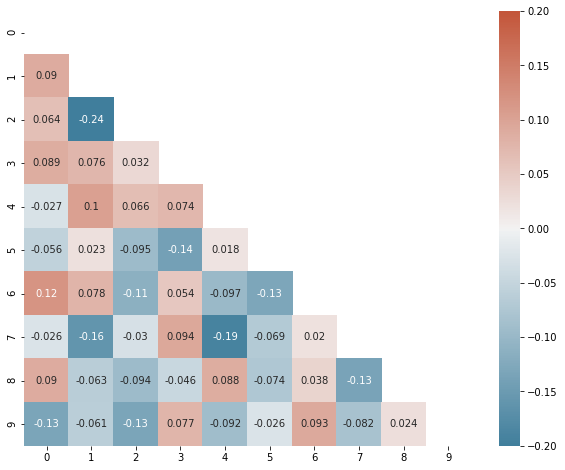

In [5]:
df = pd.DataFrame(X).corr()

plt.subplots(figsize=(10, 8)) 
# remove upper triangle
mask = np.triu(np.ones_like(df, dtype=bool))
sns.heatmap(df, vmin=-.2, vmax=.2, annot=True, mask=mask,
            cmap=sns.diverging_palette(230, 20, as_cmap=True))

# Train and Explain

In [30]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [6]:
n_jobs = 4
outer_cv = 5

kf = RepeatedStratifiedKFold(n_splits=outer_cv, n_repeats=10)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/outer_cv, random_state=random_state)

# Logistic Regression

In [ ]:
lr = LogisticRegression(penalty='none').fit(X, y)

pd.Series(lr.coef_.flatten()).plot.bar()

<AxesSubplot:>

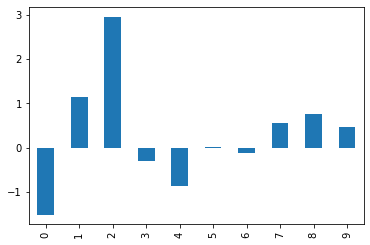

In [10]:
lr = LogisticRegression(penalty='none').fit(X_train, y_train)

pd.Series(lr.coef_.flatten()).plot.bar()

<AxesSubplot:>

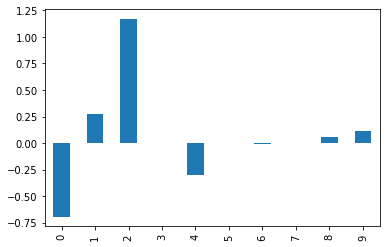

In [11]:
lr = LogisticRegressionCV(penalty='l1', solver="liblinear").fit(X_train, y_train)

pd.Series(lr.coef_.flatten()).plot.bar()

<AxesSubplot:>

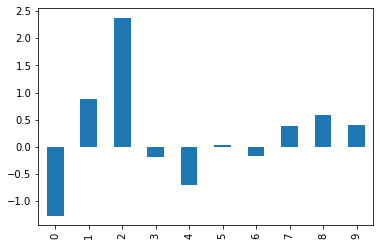

In [12]:
lr = LogisticRegressionCV(penalty='l2').fit(X_train, y_train)

pd.Series(lr.coef_.flatten()).plot.bar()

<AxesSubplot:>

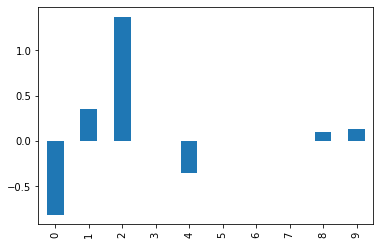

In [13]:
lr = LogisticRegressionCV(penalty='elasticnet', solver='saga', max_iter=500, l1_ratios=[0.1, 0.5, 0.9]).fit(X_train, y_train)

pd.Series(lr.coef_.flatten()).plot.bar()

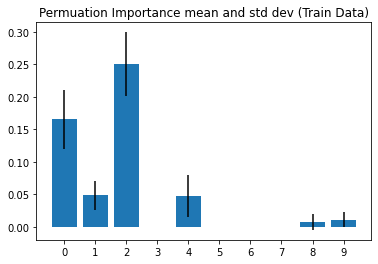

In [50]:
pi = permutation_importance(lr, X_train, y_train, n_repeats=20, random_state=random_state)

plt.figure()
plt.title("Permuation Importance mean and std dev (Train Data)")

plt.bar(range(X.shape[1]), pi.importances_mean, yerr=pi.importances_std)
plt.xticks(range(X.shape[1]));

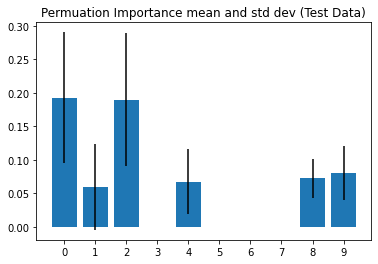

In [51]:
pi = permutation_importance(lr, X_test, y_test, n_repeats=20, random_state=random_state)

plt.figure()
plt.title("Permuation Importance mean and std dev (Test Data)")

plt.bar(range(X.shape[1]), pi.importances_mean, yerr=pi.importances_std)
plt.xticks(range(X.shape[1]));

# Random Forest

<AxesSubplot:>

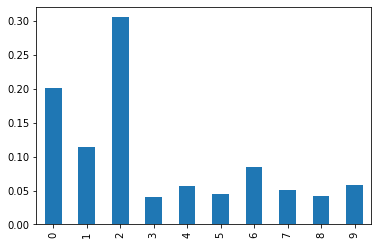

In [14]:
rf = RandomForestClassifier(random_state=random_state).fit(X_train, y_train)

pd.Series(rf.feature_importances_).plot.bar()

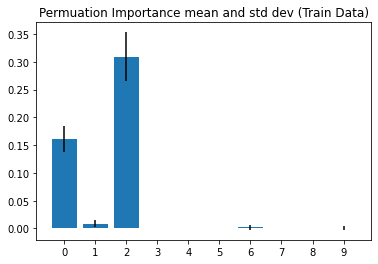

In [48]:
pi = permutation_importance(rf, X_train, y_train, n_repeats=20, random_state=random_state)

plt.figure()
plt.title("Permuation Importance mean and std dev (Train Data)")

plt.bar(range(X.shape[1]), pi.importances_mean, yerr=pi.importances_std)
plt.xticks(range(X.shape[1]));

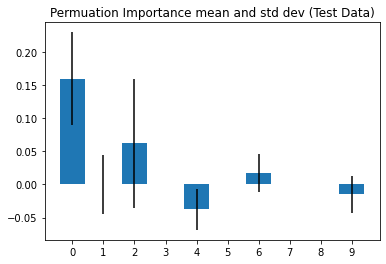

In [49]:
pi = permutation_importance(rf, X_test, y_test, n_repeats=20, random_state=random_state)

plt.figure()
plt.title("Permuation Importance mean and std dev (Test Data)")

plt.bar(range(X.shape[1]), pi.importances_mean, yerr=pi.importances_std)
plt.xticks(range(X.shape[1]));

(-1.0, 10.0)

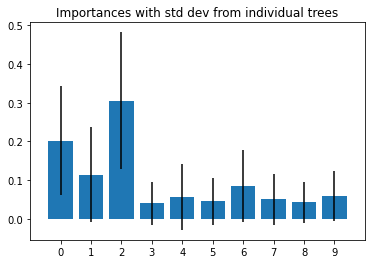

In [15]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)

plt.figure()
plt.title("Importances with std dev from individual trees")
plt.bar(range(X.shape[1]), importances, yerr=std, align="center")
plt.xticks(range(X.shape[1]))
plt.xlim([-1, X.shape[1]])

In [16]:
from sklearn.model_selection import cross_validate

In [17]:
est = RandomForestClassifier(random_state=random_state)

cv_results = cross_validate(est, X, y, cv=kf, return_estimator=True)

In [19]:
imps = get_importances_from_cv(cv_results, column_names=columns, debug=True)
imps.shape

50 models in cv_results


(500, 2)

In [58]:
df = summarise_importances(imps, sort=False)
df

,count,mean,abs_mean,std
feature,,,,
0,50.0,0.236674,0.236674,0.027529
1,50.0,0.118985,0.118985,0.016941
2,50.0,0.280501,0.280501,0.026826
3,50.0,0.046765,0.046765,0.009440
4,50.0,0.056369,0.056369,0.011861
5,50.0,0.047423,0.047423,0.009144
6,50.0,0.064121,0.064121,0.009425
7,50.0,0.050173,0.050173,0.007967
8,50.0,0.047662,0.047662,0.007622


<AxesSubplot:title={'center':'Importances with std dev from CV'}, xlabel='feature'>

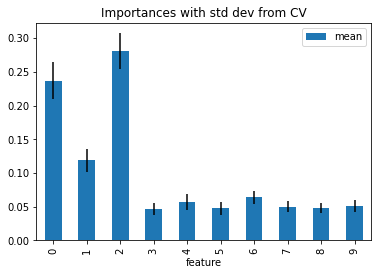

In [59]:
df.plot(kind = "bar", y = "mean", legend = True, title = "Importances with std dev from CV", yerr = "std")

# Gradient Boosting

<AxesSubplot:title={'center':'Importances with std dev from CV'}, xlabel='feature'>

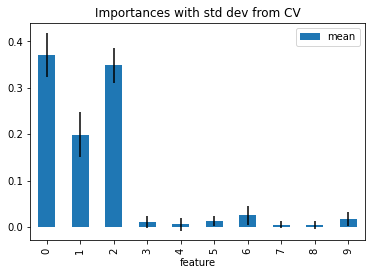

In [77]:
est = GradientBoostingClassifier(random_state=random_state)

cv_results = cross_validate(est, X, y, cv=kf, return_estimator=True)
imps = get_importances_from_cv(cv_results, column_names=columns)
df = summarise_importances(imps, sort=False)
df.plot(kind = "bar", y = "mean", legend = True, title = "Importances with std dev from CV", yerr = "std")

<AxesSubplot:title={'center':'Importances with std dev from CV'}, xlabel='feature'>

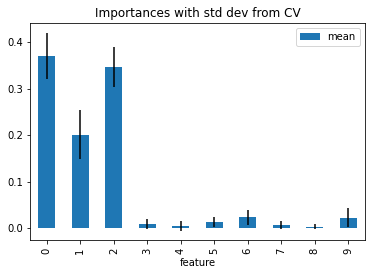

In [83]:
# pretty much the same as:
# est = GradientBoostingClassifier(n_estimators=5000, learning_rate=0.001)
est = GradientBoostingClassifier(n_estimators=1000)

cv_results = cross_validate(est, X, y, cv=kf, return_estimator=True, n_jobs=n_jobs)
imps = get_importances_from_cv(cv_results, column_names=columns)
df = summarise_importances(imps, sort=False)

df.plot(kind = "bar", y = "mean", legend = True, title = "Importances with std dev from CV", yerr = "std")

# XGBoost

In [55]:
from xgboost import XGBClassifier

[13:54:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:>

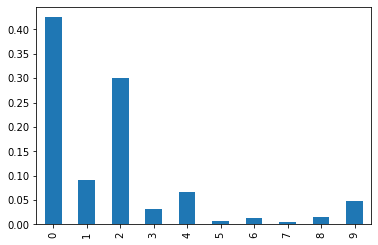

In [69]:
# defaults: 100 estimators, gain importance
xgb = XGBClassifier(n_estimators=100, importance_type='gain', random_state=random_state).fit(X_train, y_train)

pd.Series(xgb.feature_importances_).plot.bar()

[13:55:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

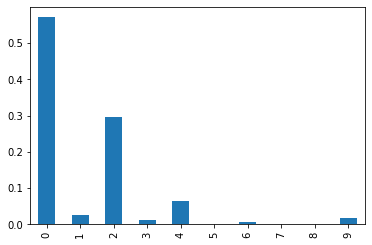

In [71]:
xgb = XGBClassifier(n_estimators=1000, importance_type='gain', random_state=random_state).fit(X_train, y_train)

pd.Series(xgb.feature_importances_).plot.bar()

[13:56:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:>

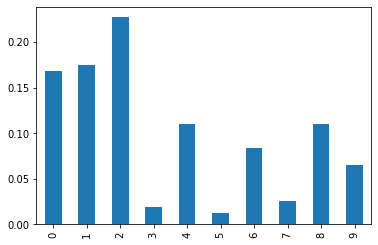

In [72]:
# "weight" importance seems inaccurate
xgb = XGBClassifier(n_estimators=100, importance_type='weight', random_state=random_state).fit(X_train, y_train)

pd.Series(xgb.feature_importances_).plot.bar()